In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt 
import re
import seaborn as sns
import numpy as np
from modules.neighbor_loader import LastNeighborLoaderTGNPL
from tgb.linkproppred.dataset_pyg import PyGLinkPropPredDataset, PyGLinkPropPredDatasetHyper
from modules.emb_module import *
from modules.time_enc import TimeEncoder
from sklearn.metrics import precision_recall_curve


In [2]:
data = pd.read_table(f'./data/observed_transactions.psv', sep="|")
NUM_FIRMS = len(set(data['origin_company']).union(set(data['dest_company'])))
NUM_PRODUCTS = len(set(data['product']))
NUM_NODES = NUM_FIRMS+NUM_PRODUCTS
print(f"There are {NUM_FIRMS} firms and {NUM_PRODUCTS} products")
min(set(data['product'])), max(set(data['product'])), len(set(data['product']))

There are 21 firms and 97 products


('product0', 'product99', 97)

In [3]:
# Detect missing products
prod_before2after = {}
missing_prods = []
cnt = 0
for i in range(100):
    target_str = f"product{i}"
    if target_str not in set(data['product']):
        print(f"{target_str} is missing")
        missing_prods.append(target_str)
        continue
    prod_before2after[f"product{i}"] = f"product{cnt}"
    cnt += 1
missing_prods

product26 is missing
product78 is missing
product93 is missing


['product26', 'product78', 'product93']

## Get ground-truth BOM? 

In [4]:
# Read in overall psv
df = pd.read_table(f'./data/production_fn.psv', sep= "|") 
print(f"Import production_fn.psv as df with shape {df.shape}")

# Filter out relationships with missing_prods
f = df['product'].str.contains('|'.join(missing_prods)) | df['prod_func'].str.contains('|'.join(missing_prods))
df = df[~f]
print(f"df shape after filtering out missing products {df.shape}")
df.iloc[0]["prod_func"]

Import production_fn.psv as df with shape (280, 2)
df shape after filtering out missing products (269, 2)


'0.734(company1-product23)+ 0.881(company16-product20)+ 0.588(company16-product12)+ 0.432(company0-product57)+ 0.201(company3-product85)+ 0.785(company3-product99)'

In [5]:
# Apply new mapping to products
for before_prod, after_prod in prod_before2after.items():
    # note: since we replace prod_x with prod_y (y<=x), so there'll NOT be repeated replacement of the same str
    df['product'] = df['product'].str.replace(before_prod, after_prod)
    df['prod_func'] = df['prod_func'].str.replace(before_prod, after_prod)
df.iloc[0]["prod_func"]

'0.734(company1-product23)+ 0.881(company16-product20)+ 0.588(company16-product12)+ 0.432(company0-product56)+ 0.201(company3-product83)+ 0.785(company3-product96)'

In [6]:
# Recognize relationship type
nonlinear_op_matches= ["ExoProd", "^", "/"] # "min" and "/" appear together, "^" and "x" appear together
for op_match in nonlinear_op_matches:
    df[op_match] = [sum([op_match in value])>0 for value in df["prod_func"]]
df["linear"] = [sum([op in value for op in nonlinear_op_matches])==0 for value in df["prod_func"]]
df.head()

,product,prod_func,ExoProd,^,/,linear
1,company0-product87,0.734(company1-product23)+ 0.881(company16-pro...,False,False,False,True
2,company0-product18,2.848174813753853 x (company16-product61)^0.48...,False,True,False,False
3,company0-product92,min{(company5-product25)/0.386},False,False,True,False
4,company0-product64,0.488(company0-product43)+ 0.279(company12-pro...,False,False,False,True
5,company0-product23,ExoProd[0.0087],True,False,False,False


In [7]:
# Regex handling to elicit company, supply_prod, list of buy_prod from strings for later use
company_lambda = lambda row: int(re.split('company|-product', row["product"])[1])
supply_prod_lambda = lambda row: int(re.split('company|-product', row["product"])[2])
buy_prod_list_lambda = lambda row: [int(p) for p in re.split('product|\)', row["prod_func"])[1::2]]

df["company"] = df.apply(company_lambda, axis=1)
df["supply_prod"] = df.apply(supply_prod_lambda, axis=1)
df["buy_prod_list"] = df.apply(buy_prod_list_lambda, axis=1)

print(f"After preprocessing, df has shape {df.shape}")
df.head()

After preprocessing, df has shape (269, 9)


,product,prod_func,ExoProd,^,/,linear,company,supply_prod,buy_prod_list
1,company0-product87,0.734(company1-product23)+ 0.881(company16-pro...,False,False,False,True,0,87,"[23, 20, 12, 56, 83, 96]"
2,company0-product18,2.848174813753853 x (company16-product61)^0.48...,False,True,False,False,0,18,"[61, 5]"
3,company0-product92,min{(company5-product25)/0.386},False,False,True,False,0,92,[25]
4,company0-product64,0.488(company0-product43)+ 0.279(company12-pro...,False,False,False,True,0,64,"[43, 58, 46]"
5,company0-product23,ExoProd[0.0087],True,False,False,False,0,23,[]


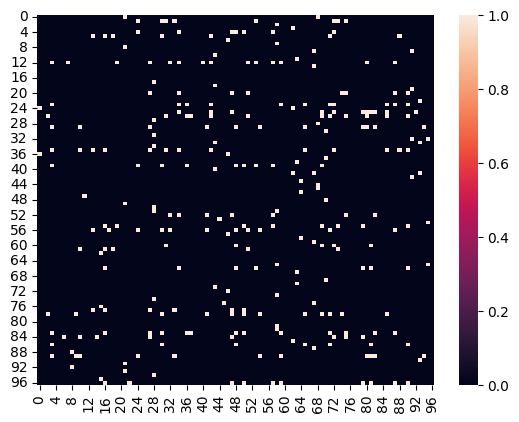

In [8]:
# Construct true attention matrix
am_true = np.zeros([NUM_PRODUCTS, NUM_PRODUCTS]) # a_{buy_prod, supply_prod}
for idx, row in df.iterrows():
    supply_prod = row['supply_prod']
    buy_prod_list = row['buy_prod_list']
    for buy_prod in buy_prod_list:
        am_true[buy_prod][supply_prod] = 1 
    # Note: recall that a_{kl} represents use prod k (buy) to produce prod l (supply)

sns.heatmap(am_true, annot=False, fmt=".1f")
plt.show()

## Evaluation Design

In [9]:
# Precision recall curve
def plot_precision_recall_curve(am_true, am_pred, label=""):
    precision, recall, thresholds = precision_recall_curve(am_true.flatten(), am_pred.flatten())
    plt.figure(figsize=(4,2))
    plt.plot(recall, precision)  
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.title(f"precision vs. recall curve for {label}")
    plt.show()

In [23]:
# Ranking curve: for each supply prod, how many are ranked top THRESHOLD (default: # shown up in prod_func)
# Note: recall attention matrix is of this form a_{buy_prod, supply_prod}
MAX = 150
def get_rankings(am_true, am_pred):
    true_rankings, pred_rankings = [], []
    for supply_prod in range(NUM_PRODUCTS):

        y_true = am_true[:,supply_prod] # always 0, 1
        y_pred = am_pred[:,supply_prod]

        sorted_true = sorted(range(len(y_true)), key=lambda k: y_true[k], reverse=True) # sort the index
        sorted_pred = sorted(range(len(y_pred)), key=lambda k: y_pred[k], reverse=True)
        COUNT = int(sum(y_true)) # # buy products that has true production relationship with the fixed supply prod

        # for every true, get the ranking of the value in pred
        rankings = []
        for true_value in sorted_true[:COUNT]:
            rankings.append(sorted_pred.index(true_value))
        true_rankings.append(sum(range(COUNT)) / COUNT if COUNT > 0 else MAX) # avg true ranking
        # we care about pred_rankings
        pred_rankings.append(sum(rankings) / len(rankings) if len(rankings) > 0 else MAX) # avg pred ranking
    return true_rankings, pred_rankings

def plot_rankings(am_true, am_pred, label=""):
    true_rankings, pred_rankings = get_rankings(am_true, am_bstatic)
    plt.figure(figsize=(6,6))
    plt.scatter(range(NUM_PRODUCTS), true_rankings, color="r", label="true ranking")  
    plt.scatter(range(NUM_PRODUCTS), pred_rankings, color="b", label="pred ranking")  
    plt.xlabel("supply product")
    plt.ylabel("average ranking")
    plt.title(f"true vs pred ranking curve for {label}") # the lower the better
    plt.show()

## Static Attention Matrix Analysis

In [27]:
# Helper function copied from tgnpl.py
def repeat_tensor(t, k):
    """
    When k = 2, tensor([1, 2, 3]) becomes tensor([1, 1, 2, 2, 3, 3]).
    Used to align the ordering of neighbor loader 'e_id' and data
    """
    if len(t.shape)==1:
        return t.reshape(-1, 1).repeat(1, k).reshape(t.shape[0]*k)
    elif len(t.shape)==2:
        return t.reshape(-1, 1).repeat(1, k).reshape(t.shape[0]*k, 1)
    else:
        raise Exception("repeat_tensor: Not Applicable")
        
def get_static_attention_matrix(model, emb_dim=100):
    p_id = range(NUM_FIRMS, NUM_FIRMS+NUM_PRODUCTS) # all product IDs
    
    # calculate prod_embs
    if len(static_inv['gnn'])==0: # when gnn is IdentityFunction()
        prod_embs = model['memory']['memory.weight'][p_id].cpu() # [num_products x emb_dim]
    else: # when gnn is GraphAttentionEmbedding()
        device = 'cuda'
        dataset = PyGLinkPropPredDatasetHyper(name="tgbl-hypergraph_synthetic", root="datasets", 
                                          use_prev_sampling = True)
        data = dataset.get_TemporalData().to(device)

        # Helper vector to map global node indices to local ones
        assoc = torch.empty(NUM_NODES, dtype=torch.long, device=device)
        # get product embeddings
        f_id = torch.Tensor([]).long().to(device)  # we only need embeddings for products, not firms
        p_id = torch.arange(NUM_FIRMS, NUM_FIRMS+NUM_PRODUCTS, device=device).long()  # all product IDs
        n_id, edge_index, e_id = model['neighbor_loader'](f_id, p_id)  # n_id contains p_id and its neighbors
        assoc[n_id] = torch.arange(n_id.size(0), device=device)  # maps original ID to row in z
        memory, last_update, update_loss = model['memory']['memory.weight'][n_id], model['memory']['last_update'][n_id], 0
        gnn = GraphAttentionEmbedding(emb_dim, emb_dim, 1, TimeEncoder(100)).to(device) # assume mem_dim, emb_dim, time_dim=100; msg_dim=1
        gnn.load_state_dict(model['gnn'])
        z = gnn(
            memory,
            last_update,
            edge_index,
            repeat_tensor(data.t, 2)[e_id].to(device),
            repeat_tensor(data.msg, 2)[e_id].to(device),
        )
        prod_embs = z[assoc[p_id]].detach().cpu() # [num_products x emb_dim]
        
    prod_bilinear = model['inventory']['prod_bilinear'].cpu() # [emb_dim x emb_dim]
    att_weights = prod_embs @ (prod_bilinear @ prod_embs.T)
    return torch.nn.ReLU(inplace=False)(att_weights).cpu()

In [28]:
# STATIC + ID load in best vs final
MODEL_DIR = "/lfs/local/0/zhiyinl/supply-chains/TGB/examples/linkproppred/general/saved_models/"
MODEL_NAME = "TGNPL_tgbl-hypergraph_synthetic_0.0001_200_10_100_1_100_100_100_1e-06_100.0_1_False_True_False_static_id_True_5.0_1_1_0_-1_False_False_2024_01_29-00_15_50"
static_inv = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0.pth")
static_inv_final = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0_final.pth")
print(static_inv['inventory'].keys(), static_inv_final['inventory'].keys())

odict_keys(['prod_bilinear']) odict_keys(['prod_bilinear'])


In [29]:
# Get attention matrix: best (epoch 12) vs final (epoch 99)
am_bstatic = get_static_attention_matrix(static_inv)
print(f"Best static attention matrix has max {am_bstatic.max()} and min {am_bstatic.min()} and shape {am_bstatic.shape}")

am_fstatic = get_static_attention_matrix(static_inv_final)
print(f"Final static attention matrix has max {am_fstatic.max()} and min {am_fstatic.min()} and shape {am_fstatic.shape}")

Best static attention matrix has max 68.27583312988281 and min 0.0 and shape torch.Size([97, 97])
Final static attention matrix has max 44.707698822021484 and min 0.0 and shape torch.Size([97, 97])


Below is static best attention matrix


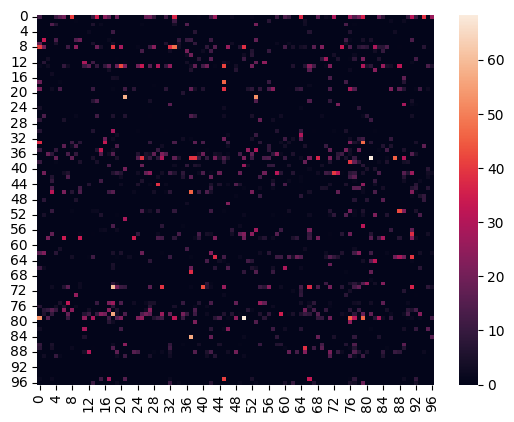

Below is static final attention matrix


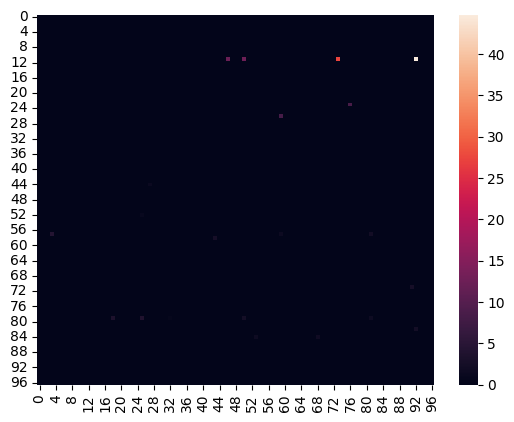

In [30]:
# Heatmap Visualization
print("Below is static best attention matrix")
sns.heatmap(am_bstatic, annot=False, fmt=".1f")
plt.show()

print("Below is static final attention matrix")
sns.heatmap(am_fstatic, annot=False, fmt=".1f")
plt.show()

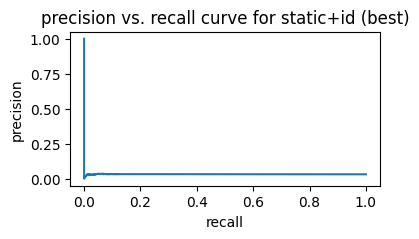

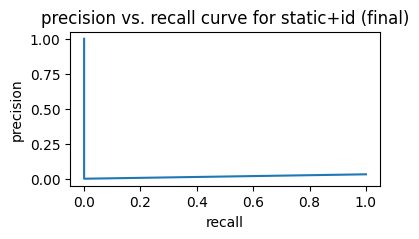

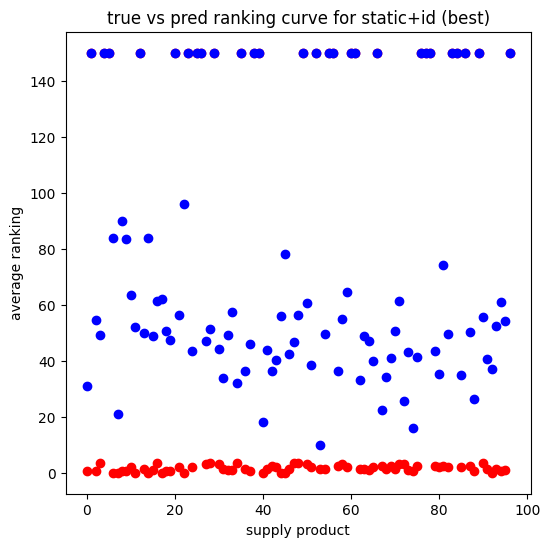

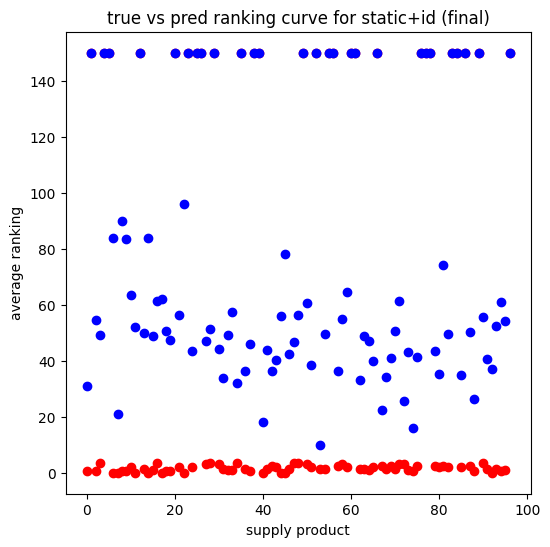

In [31]:
# Evaluate with precision + recall curve
plot_precision_recall_curve(am_true, am_bstatic, "static+id (best)") # am_true, am_bstatic [NUM_PRODS x NUM_PRODS]
plot_precision_recall_curve(am_true, am_fstatic, "static+id (final)")

# Evaluate with ranking
plot_rankings(am_true, am_bstatic, "static+id (best)")
plot_rankings(am_true, am_bstatic, "static+id (final)")

tensor(104.4613)


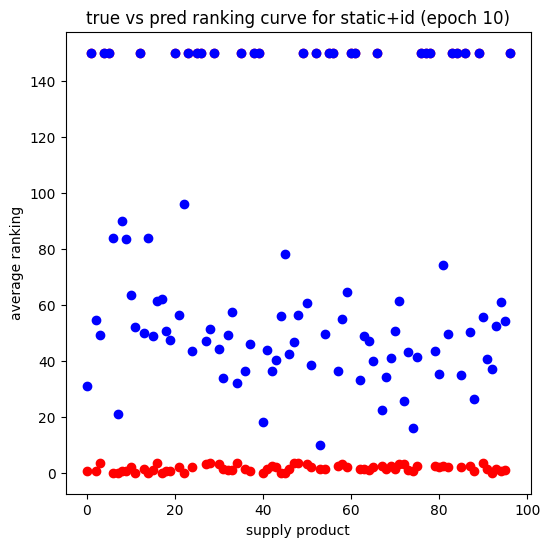

tensor(41.1411)


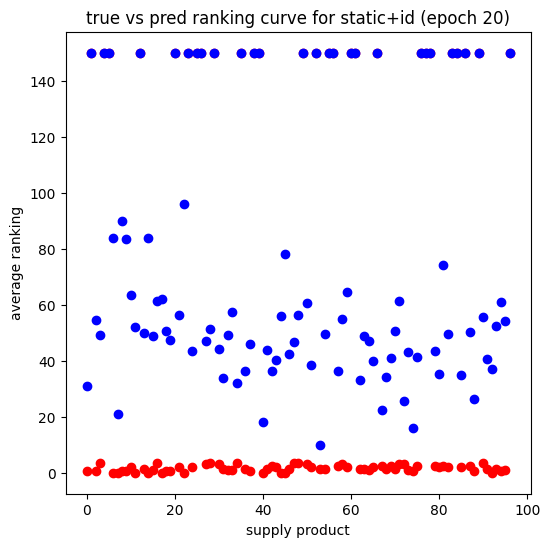

tensor(3.1248)


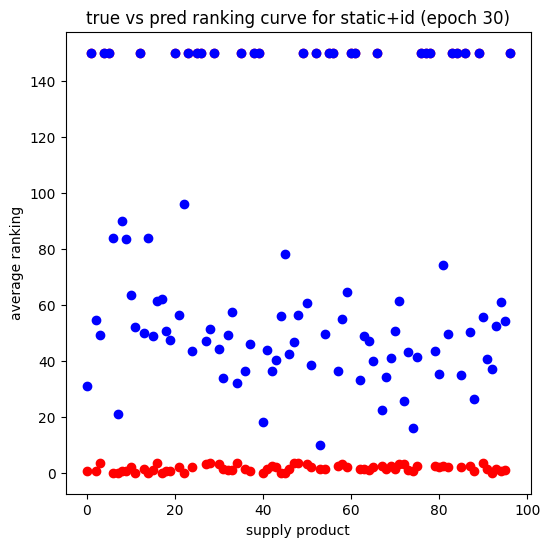

tensor(3.0957)


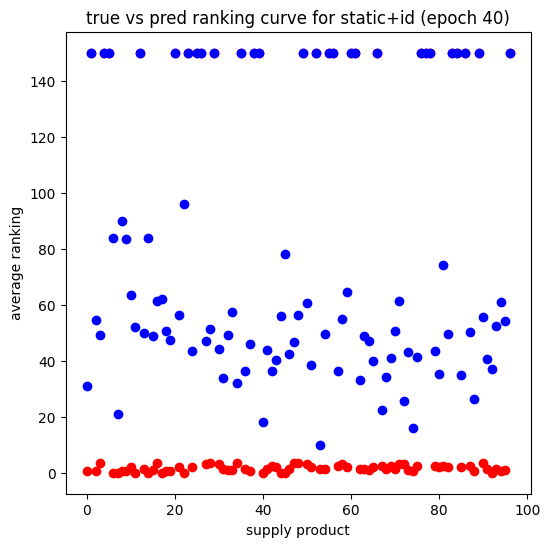

tensor(10.1062)


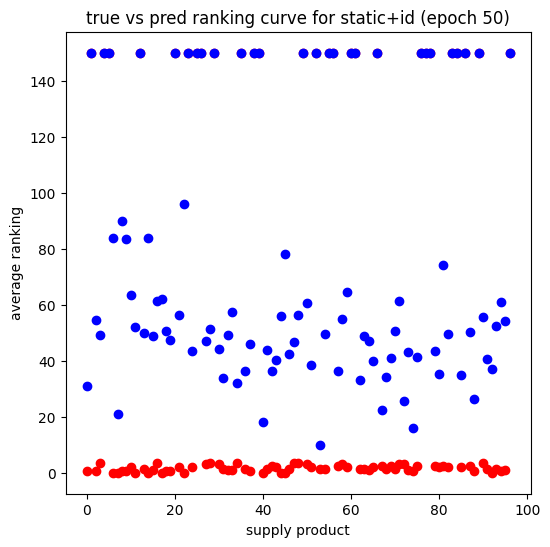

tensor(2.9894)


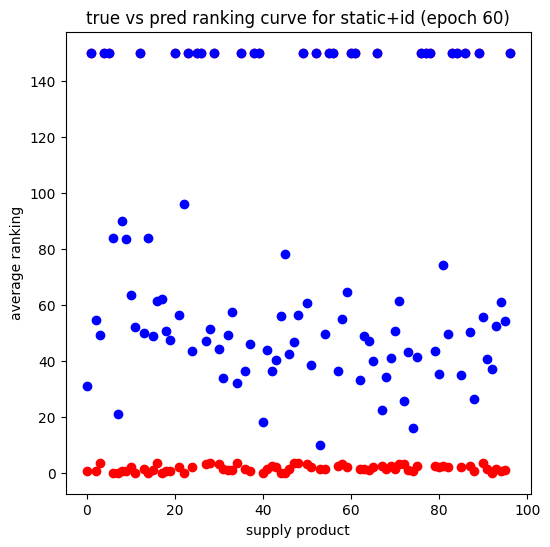

tensor(0.)


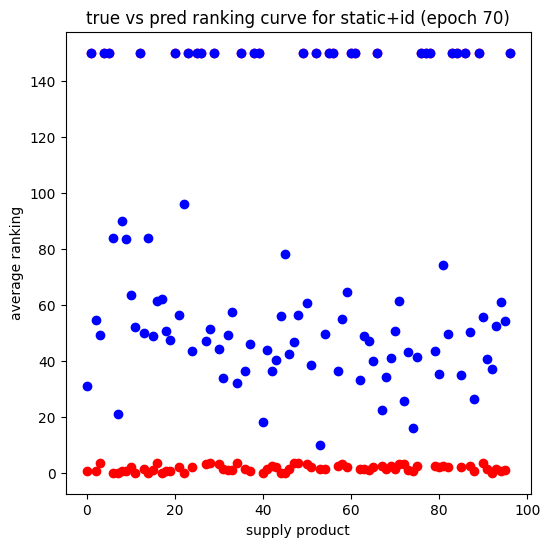

tensor(0.)


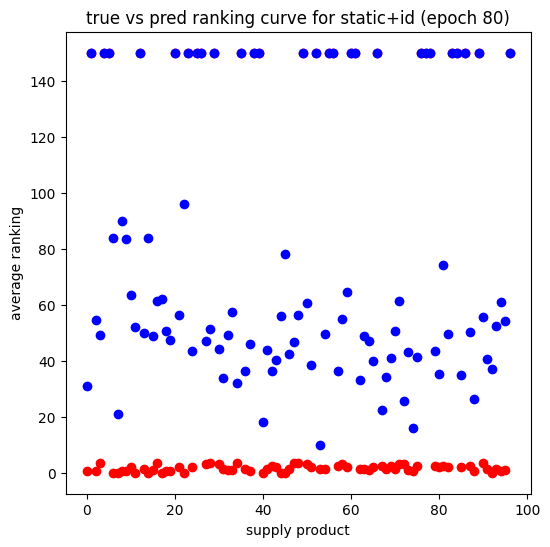

tensor(41.1403)


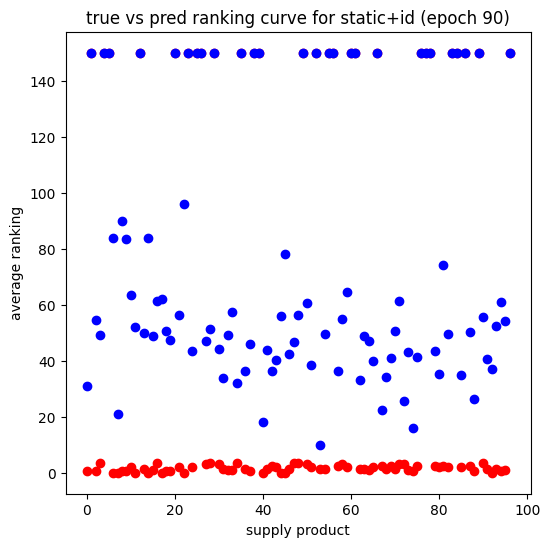

tensor(44.7077)


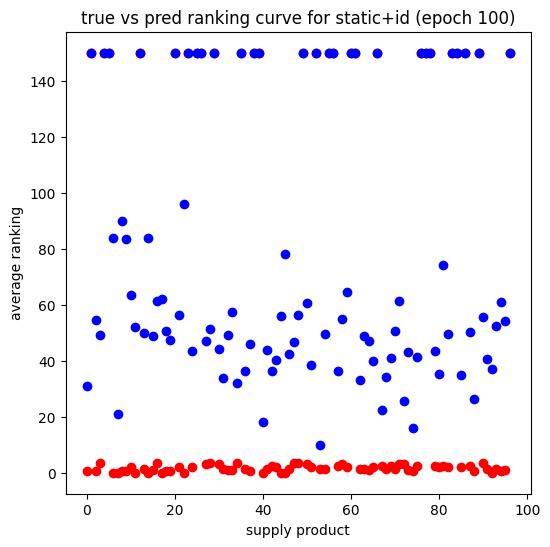

In [33]:
# What about plotting for the model every ten epochs? 
for epoch in range(10, 101, 10):
    # STATIC + ID at this epoch
    static_epoch = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0_{epoch}.pth")
    am_estatic = get_static_attention_matrix(static_epoch)
    # plot_precision_recall_curve(am_true, am_estatic, f"static+id (epoch {epoch})")
    plot_rankings(am_true, am_estatic, f"static+id (epoch {epoch})")
    
# The performance seems to be good at the start and gets worse as we train for more epochs

odict_keys(['prod_bilinear']) odict_keys(['prod_bilinear'])
Dataset tgbl-hypergraph_synthetic url not found, download not supported yet.
file found, skipping download
Dataset directory is  /lfs/turing1/0/zhiyinl/supply-chains/TGB/tgb/datasets/tgbl_hypergraph_synthetic
loading processed file
Best static attention matrix has max 21432422.0 and min 0.0 and shape torch.Size([97, 97])
Dataset tgbl-hypergraph_synthetic url not found, download not supported yet.
file found, skipping download
Dataset directory is  /lfs/turing1/0/zhiyinl/supply-chains/TGB/tgb/datasets/tgbl_hypergraph_synthetic
loading processed file
Final static attention matrix has max 13712935.0 and min 0.0 and shape torch.Size([97, 97])
Below is static best attention matrix


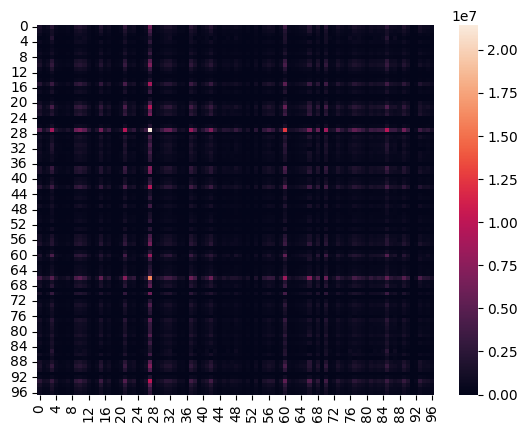

Below is static final attention matrix


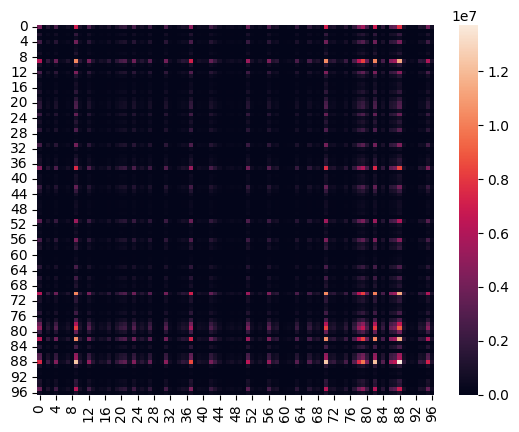

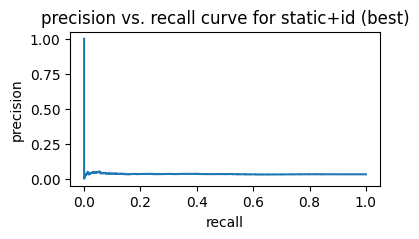

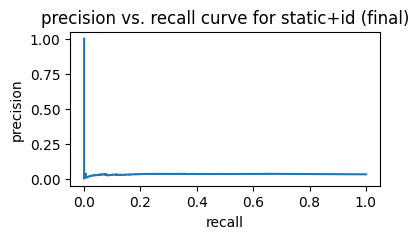

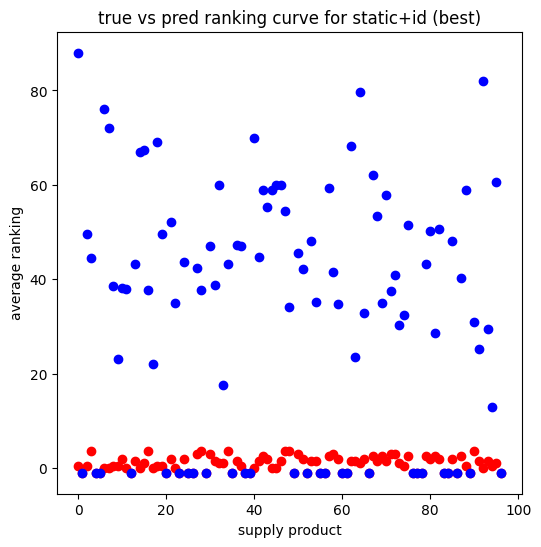

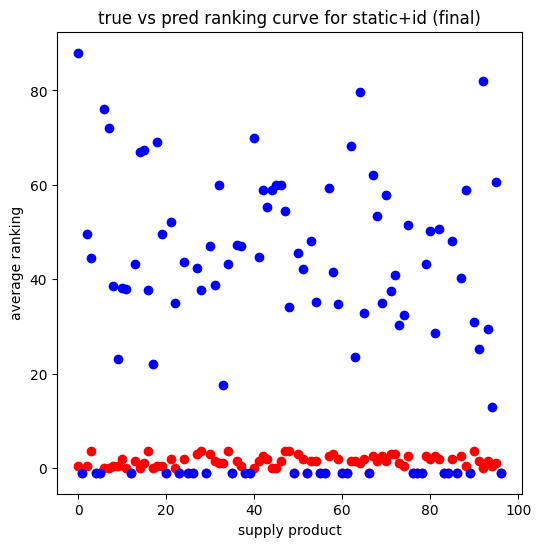

In [17]:
# What about static+id with mem_dim, emb_dim=1000? 
# STATIC + ID load in best vs final
MODEL_DIR = "/lfs/local/0/zhiyinl/supply-chains/TGB/examples/linkproppred/general/saved_models/"
MODEL_NAME = "TGNPL_tgbl-hypergraph_synthetic_0.0001_200_10_100_1_1000_100_1000_1e-06_100.0_1_False_True_False_static_attn_True_5.0_1_1_0_-1_False_False_2024_01_29-00_16_08"
static_inv = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0.pth")
static_inv_final = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0_final.pth")
print(static_inv['inventory'].keys(), static_inv_final['inventory'].keys())

# Get attention matrix: best (epoch 12) vs final (epoch 99)
am_bstatic = get_static_attention_matrix(static_inv, emb_dim=1000)
print(f"Best static attention matrix has max {am_bstatic.max()} and min {am_bstatic.min()} and shape {am_bstatic.shape}")

am_fstatic = get_static_attention_matrix(static_inv_final, emb_dim=1000)
print(f"Final static attention matrix has max {am_fstatic.max()} and min {am_fstatic.min()} and shape {am_fstatic.shape}")

# Heatmap Visualization
print("Below is static best attention matrix")
sns.heatmap(am_bstatic, annot=False, fmt=".1f")
plt.show()

print("Below is static final attention matrix")
sns.heatmap(am_fstatic, annot=False, fmt=".1f")
plt.show()

# Evaluate with precision + recall curve
plot_precision_recall_curve(am_true, am_bstatic, "static+id (best)")
plot_precision_recall_curve(am_true, am_fstatic, "static+id (final)")

# Evaluate with ranking
plot_rankings(am_true, am_bstatic, "static+id (best)")
plot_rankings(am_true, am_bstatic, "static+id (final)")

# Conclusion: This helps a bit

odict_keys(['prod_bilinear']) odict_keys(['prod_bilinear'])
Dataset tgbl-hypergraph_synthetic url not found, download not supported yet.
file found, skipping download
Dataset directory is  /lfs/turing1/0/zhiyinl/supply-chains/TGB/tgb/datasets/tgbl_hypergraph_synthetic
loading processed file
Best static attention matrix has max 3961962.25 and min 0.0 and shape torch.Size([97, 97])
Dataset tgbl-hypergraph_synthetic url not found, download not supported yet.
file found, skipping download
Dataset directory is  /lfs/turing1/0/zhiyinl/supply-chains/TGB/tgb/datasets/tgbl_hypergraph_synthetic
loading processed file
Final static attention matrix has max 3505253.5 and min 0.0 and shape torch.Size([97, 97])
Below is static best attention matrix


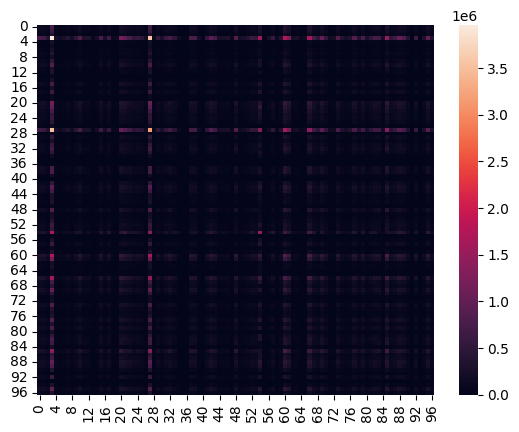

Below is static final attention matrix


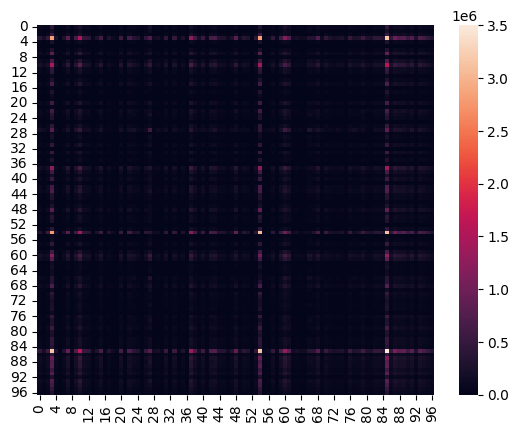

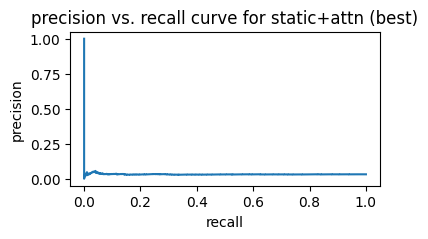

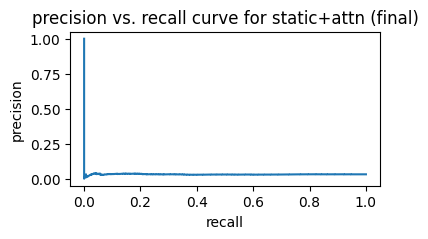

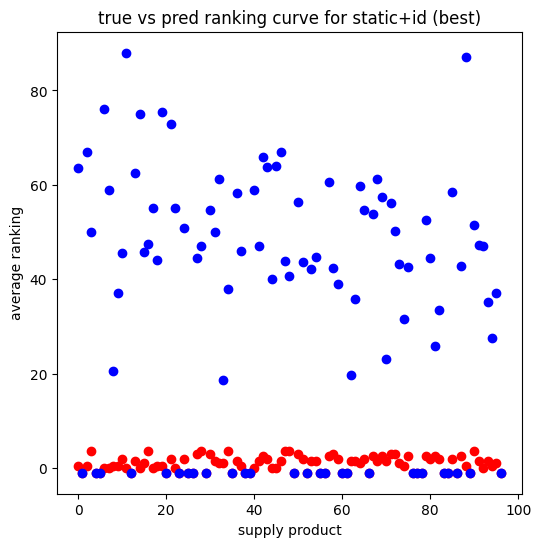

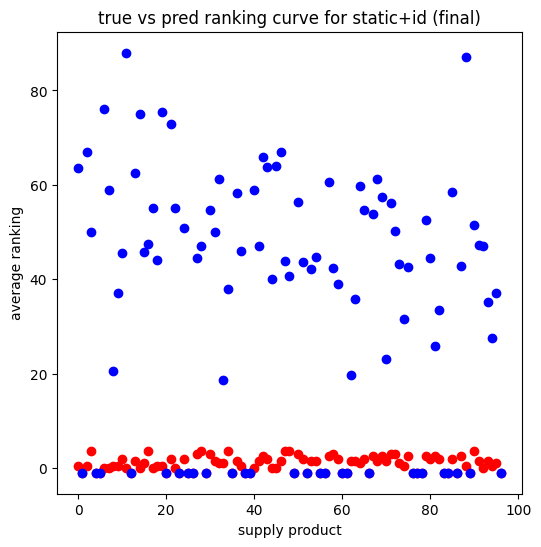

In [18]:
# What about static+attn?
# STATIC + attn load in best vs final
MODEL_DIR = "/lfs/local/0/zhiyinl/supply-chains/TGB/examples/linkproppred/general/saved_models/"
MODEL_NAME = "TGNPL_tgbl-hypergraph_synthetic_0.0001_200_10_100_1_100_100_100_1e-06_100.0_1_False_True_False_static_attn_True_5.0_1_1_0_-1_False_False_2024_01_29-00_16_12"
static_inv = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0.pth")
static_inv_final = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0_final.pth")
print(static_inv['inventory'].keys(), static_inv_final['inventory'].keys())

# Get attention matrix: best (epoch 12) vs final (epoch 99)
am_bstatic = get_static_attention_matrix(static_inv)
print(f"Best static attention matrix has max {am_bstatic.max()} and min {am_bstatic.min()} and shape {am_bstatic.shape}")

am_fstatic = get_static_attention_matrix(static_inv_final)
print(f"Final static attention matrix has max {am_fstatic.max()} and min {am_fstatic.min()} and shape {am_fstatic.shape}")

# Heatmap Visualization
print("Below is static best attention matrix")
sns.heatmap(am_bstatic, annot=False, fmt=".1f")
plt.show()

print("Below is static final attention matrix")
sns.heatmap(am_fstatic, annot=False, fmt=".1f")
plt.show()

# Evaluate with precision + recall curve
plot_precision_recall_curve(am_true, am_bstatic, "static+attn (best)")
plot_precision_recall_curve(am_true, am_fstatic, "static+attn (final)")


# Evaluate with ranking
plot_rankings(am_true, am_bstatic, "static+id (best)")
plot_rankings(am_true, am_bstatic, "static+id (final)")

# This helps a bit

In [ ]:
# Drafts below

In [ ]:
# load in models: best, final
MODEL_DIR = "/lfs/local/0/zhiyinl/supply-chains/TGB/examples/linkproppred/general/saved_models/"
MODEL_NAME = "TGNPL_tgbl-hypergraph_synthetic_0.0001_200_10_1_1_100_100_100_1e-06_100.0_1_False_True_False_static_attn_True_5.0_1_1_0_-1_False_False_2024_01_28-23_45_27"
# TODO: change MODEL_NAME
static_inv = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0.pth")
static_inv_final = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0_final.pth")
print(static_inv['inventory'].keys(), static_inv_final['inventory'].keys())

In [ ]:
# get static + attn attention matrix: best (epoch TODO) vs final (epoch TODO)
am_bstatic = get_static_attention_matrix(static_inv)
print(f"Best static attention matrix has max {am_bstatic.max()} and min {am_bstatic.min()} and shape {am_bstatic.shape}")

am_fstatic = get_static_attention_matrix(static_inv_final)
print(f"Final static attention matrix has max {am_fstatic.max()} and min {am_fstatic.min()} and shape {am_fstatic.shape}")

In [ ]:
# Heatmap Visualization
print("Below is static best attention matrix")
sns.heatmap(am_bstatic, annot=False, fmt=".1f")
plt.show()

print("Below is static final attention matrix")
sns.heatmap(am_fstatic, annot=False, fmt=".1f")
plt.show()

In [ ]:
# Does TGNPL attention matrix captures all the ground truth?
def get_fraction_uncaptured(am, THRESHOLD):
    not_captured_cnt = 0 # count of total true relationship that are not captured
    total_cnt = 0 # total true relationship
    for iy, ix in np.ndindex(am_true.shape):
        if am_true[iy, ix] == 1:
            total_cnt += 1
            if am[iy, ix] < THRESHOLD:
    #             print(f"ground_truth buy prod{iy} -> supply prod{ix} is NOT captured")
                not_captured_cnt += 1
    return not_captured_cnt / float(total_cnt)

# print("plotting am_btgnpl")
# plt.figure(figsize=(3,3))
# fractions = []
# for THRESHOLD in np.linspace(0,1,11):
#     fractions.append(get_fraction_uncaptured(am_btgnpl, THRESHOLD))
# plt.plot(np.linspace(0, 1, 11), fractions, color='red')

# print("plotting am_ftgnpl")
# fractions = []
# for THRESHOLD in np.linspace(0,1,11):
#     fractions.append(get_fraction_uncaptured(am_ftgnpl, THRESHOLD))
# plt.plot(np.linspace(0, 1, 11), fractions, color='green')
# plt.axline([0, 0], slope=1)
# plt.xlabel("THRESHOLD for attention")
# plt.ylabel("Fraction of not captured relationship")
# plt.title("TGNPL Threshold vs Fraction of uncaptured for Best (red), Final (green)")
# plt.show()

# What about static attention matrix captures all the ground truth? 
print("plotting am_bstatic")
plt.figure(figsize=(3,3))
fractions = []
for THRESHOLD in np.linspace(0,1,11):
    fractions.append(get_fraction_uncaptured(am_bstatic, THRESHOLD))
plt.plot(np.linspace(0, 1, 11), fractions, color='red')
print("plotting am_fstatic")
fractions = []
for THRESHOLD in np.linspace(0,1,11):
    fractions.append(get_fraction_uncaptured(am_fstatic, THRESHOLD))
plt.plot(np.linspace(0, 1, 11), fractions, color='green')

plt.axline([0, 0], slope=1)
plt.xlabel("THRESHOLD for attention")
plt.ylabel("Fraction of not captured relationship")
plt.title("Static Threshold vs Fraction of uncaptured for Best (red), Final (green)")
plt.show()
# the lower than y=x, the better
# we expect static final is better (lower) than static best... not sure

In [ ]:
# Method 1: ROC curve

        

    

In [ ]:

# MODEL_NAME = "TGNPL_tgbl-hypergraph_synthetic_0.0001_200_10_100_1_100_100_100_1e-06_100.0_1_False_True_False_tgnpl_id_False_10_1_1_0_-1_False_False_2024_01_22-00_19_00"
# tgnpl = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0.pth")
# print(tgnpl['memory'].keys())

# MODEL_NAME = "TGNPL_tgbl-hypergraph_synthetic_0.0001_200_10_100_1_100_100_100_1e-06_100.0_1_False_True_False_tgnpl_id_True_5.0_1_1_0_-1_False_False_2024_01_22-00_20_45"
# tgnpl_inv = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0.pth")
# tgnpl_inv_final = torch.load(f"{MODEL_DIR}{MODEL_NAME}_0_final.pth")
# print(tgnpl_inv['inventory'].keys(), tgnpl_inv_final['inventory'].keys())


In [ ]:
# Analyze TGNPL model attention matrix: best (epoch 98) vs final (epoch 98)
am_btgnpl = tgnpl_inv['inventory']['prod_bilinear'].cpu()
print(f"Best TGNPL attention matrix has max {am_btgnpl.max()} and min {am_btgnpl.min()}")

am_ftgnpl = tgnpl_inv_final['inventory']['prod_bilinear'].cpu()
print(f"Final TGNPL attention matrix has max {am_ftgnpl.max()} and min {am_ftgnpl.min()}")

In [ ]:
# Check distribution of static attention matrix, both seem to be normal
plt.figure(figsize=(3,2))
plt.hist(am_btgnpl.flatten(), bins=20)
plt.title("Distribution of TGNPL attention matrix (best)")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(am_ftgnpl.flatten(), bins=20)
plt.title("Distribution of TGNPL attention matrix (final)")
plt.show()

In [ ]:
# Visualization - 100 by 100 heatmap (TGNPL)
print("Below is TGNPL best attention matrix")
sns.heatmap(am_btgnpl, annot=False, fmt=".1f")
plt.show()

print("Threshold > 0.9 is TGNPL best attention matrix")
sns.heatmap(am_btgnpl>0.9, annot=False, fmt=".1f")
plt.show()
# Hmm still unclear to see by eyes

### Threshold Plotting

In [ ]:
# Check distribution of static attention matrix, both seem to be normal
plt.figure(figsize=(3,2))
plt.hist(am_bstatic.flatten(), bins=20)
plt.title("Distribution of static attention matrix (best)")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(am_fstatic.flatten(), bins=20)
plt.title("Distribution of static attention matrix (final)")
plt.show()

In [ ]:
# Visualization - 100 by 100 heatmap (Static)
print("Below is static best attention matrix")
sns.heatmap(am_bstatic, annot=False, fmt=".1f")
plt.show()

print("Threshold > 0.9 is static best attention matrix")
sns.heatmap(am_bstatic>0.9, annot=False, fmt=".1f")
plt.show()
# Hmm still unclear to see by eyes

In [ ]:
# Does TGNPL attention matrix captures all the ground truth?
def get_fraction_uncaptured(am, THRESHOLD):
    not_captured_cnt = 0 # count of total true relationship that are not captured
    total_cnt = 0 # total true relationship
    for iy, ix in np.ndindex(am_true.shape):
        if am_true[iy, ix] == 1:
            total_cnt += 1
            if am[iy, ix] < THRESHOLD:
    #             print(f"ground_truth buy prod{iy} -> supply prod{ix} is NOT captured")
                not_captured_cnt += 1
    return not_captured_cnt / float(total_cnt)

print("plotting am_btgnpl")
plt.figure(figsize=(3,3))
fractions = []
for THRESHOLD in np.linspace(0,1,11):
    fractions.append(get_fraction_uncaptured(am_btgnpl, THRESHOLD))
plt.plot(np.linspace(0, 1, 11), fractions, color='red')

print("plotting am_ftgnpl")
fractions = []
for THRESHOLD in np.linspace(0,1,11):
    fractions.append(get_fraction_uncaptured(am_ftgnpl, THRESHOLD))
plt.plot(np.linspace(0, 1, 11), fractions, color='green')
plt.axline([0, 0], slope=1)
plt.xlabel("THRESHOLD for attention")
plt.ylabel("Fraction of not captured relationship")
plt.title("TGNPL Threshold vs Fraction of uncaptured for Best (red), Final (green)")
plt.show()

# What about static attention matrix captures all the ground truth? 
print("plotting am_bstatic")
plt.figure(figsize=(3,3))
fractions = []
for THRESHOLD in np.linspace(0,1,11):
    fractions.append(get_fraction_uncaptured(am_bstatic, THRESHOLD))
plt.plot(np.linspace(0, 1, 11), fractions, color='red')
print("plotting am_fstatic")
fractions = []
for THRESHOLD in np.linspace(0,1,11):
    fractions.append(get_fraction_uncaptured(am_fstatic, THRESHOLD))
plt.plot(np.linspace(0, 1, 11), fractions, color='green')

plt.axline([0, 0], slope=1)
plt.xlabel("THRESHOLD for attention")
plt.ylabel("Fraction of not captured relationship")
plt.title("Static Threshold vs Fraction of uncaptured for Best (red), Final (green)")
plt.show()
# the lower than y=x, the better
# we expect static final is better (lower) than static best... not sure

In [ ]:
# Best vs final? Can't see by eye
print("Below is static best attention matrix")
sns.heatmap(am_b, annot=False, fmt=".1f")
plt.show()

print("Below is static final attention matrix")
sns.heatmap(am_f, annot=False, fmt=".1f")
plt.show()

print("Are best and final different? Below is static best - final attention matrix")
sns.heatmap(am_b - am_f, annot=False, fmt=".1f")
plt.show()